In [31]:
import mnist_input
import mnist_model
reload(mnist_model)
import numpy as np
import tensorflow as tf
import mnist_util
reload(mnist_util)
mnist = mnist_input.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [ ]:
checkpoint_path = "/home/justin/Programming/mnist/saved_models/cnn_992.ckpt"
GRADIENT_STEP = .05

In [32]:
x = tf.placeholder("float", shape=[784])
y_ = tf.placeholder("float", shape=[10])
y_conv, keep_prob, variable_dict = mnist_model.model(x)

correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))
grad = tf.gradients(cross_entropy, x)

In [39]:

saver = tf.train.Saver(variable_dict)
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
saver.restore(sess, checkpoint_path)

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [98]:
df = pd.DataFrame()

for idx in xrange(len(mnist.test.images)):
    if idx % 100 == 0:
        print idx
    image = mnist.test.images[idx]
    y_onehot = mnist.test.labels[idx]
    label = np.argmax(y_onehot)
    pred = sess.run(y_conv, feed_dict={x:image, keep_prob:1.0})
    label1 = np.argmax(pred)

    np_grad = sess.run(grad, feed_dict={x:image, y_:y_onehot, keep_prob:1.0})
    signed_grad = np.sign(np_grad[0])
    grad_norm = sum([np.abs(w) for w in np_grad[0]])

    adv_image = GRADIENT_STEP * signed_grad + image
    pred2 = sess.run(y_conv, feed_dict={x:adv_image, keep_prob:1.0})
    label2 = np.argmax(pred2)
    
    series = pd.Series([idx, label, label1, label2, grad_norm, pred, pred2, image, adv_image],
                      index = ["Idx", "True Label", "Predicted Label", "Predicted Label Adverserial",\
                               "Gradient Norm", "Predicted Probs", "Predicted Probs Adverserial", "Image",\
                               "Adverserial Image"])
    df = df.append(series, ignore_index=True)




0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [81]:
plot = plt.hist(df["Gradient Norm"].values, bins = 30, range = [0,1])
plt.show()

In [85]:
bad_samples = df[df.apply(lambda row: row["Predicted Label"] != row["Predicted Label Adverserial"], axis = 1)]
print len(bad_samples)

203


In [86]:
bad_samples[["True Label", "Predicted Label", "Predicted Label Adverserial",\
                               "Gradient Norm"]][:10]

,True Label,Predicted Label,Predicted Label Adverserial,Gradient Norm
8,5,5,6,0.850072
18,3,3,5,28.293767
20,9,9,7,14.787411
21,6,6,5,0.869519
38,2,2,3,0.313532
48,4,4,9,0.134359
61,8,8,2,0.519690
62,9,9,5,36.533175
63,3,3,2,0.273376
65,4,4,9,1.318418


Predicted: 8


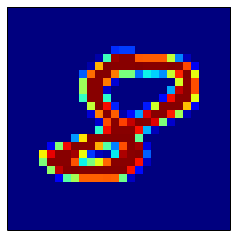

Predicted Adverserial: 2


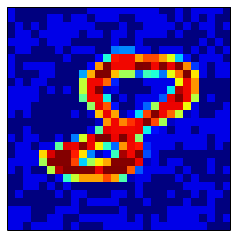

In [96]:
idx = 6
row = bad_samples.iloc[idx]
img1 = row["Image"]
img2 = row["Adverserial Image"]
print "Predicted: %d" %row["Predicted Label"]
mnist_util.plot_mnist_digit(np.reshape(img1, [28,28]))

print "Predicted Adverserial: %d" %row["Predicted Label Adverserial"]
mnist_util.plot_mnist_digit(np.reshape(img2, [28,28]))

Actual: 1, Predicted: 1
Actual 1hot:
[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
Predicted 1hot:
[  4.42696859e-07   9.99982834e-01   6.37616552e-07   7.60669025e-07
   6.41909423e-07   3.53572425e-08   2.74042145e-06   1.85791990e-07
   1.17788386e-05   5.02189543e-08] 1


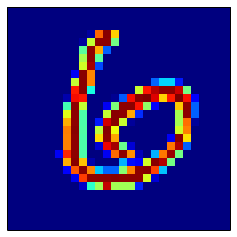

In [71]:
%matplotlib inline
tup = bad_images[11]
print "Actual: %d, Predicted: %d"%(tup[1], tup[2])
print "Actual 1hot:"
print tup[3]
print "Predicted 1hot:"
print tup[4], np.argmax(tup[4])

mnist_util.plot_mnist_digit(np.reshape(tup[0], [28,28]))
